In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [32]:
import pandas as pd
ebom = pd.read_excel("..\\assets\\inputs\\240426_EBOM_4391567_01.xlsx", 0, skiprows=5)


In [141]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Create a sample dataframe

# Create a directed graph
G = nx.DiGraph()

# Iterate over the dataframe rows
for _, row in ebom.iterrows():
    levels = row['Level'].split()
    for i in range(len(levels)):
        node = ' '.join(levels[:i+1])
        G.add_node(node, subset=i)  # Assign the subset_key attribute based on level

    for i in range(len(levels) - 1):
        parent = ' '.join(levels[:i+1])
        child = ' '.join(levels[:i+2])
        G.add_edge(parent, child)

# Compute the multipartite layout
pos = nx.multipartite_layout(G, subset_key='subset')
plt.figure(figsize=(8, 8))
# Draw the precedence graph with hierarchical layout
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, connectionstyle='arc3,rad=0.1')
plt.show()

AttributeError: 'int' object has no attribute 'split'

In [34]:
ebom["Part_Number"]

0      4391567
1     2057150X
2     2057151X
3     2057152X
4     2092564X
        ...   
56     4300759
57    2407633X
58    2407634X
59    2120433X
60     4606571
Name: Part_Number, Length: 61, dtype: object

In [36]:
import pandas as pd
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram
from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import pandas as pd
df = pd.read_xml('..\\assets\inputs\L76 Dual Passive MBOM.xml', xpath=".//weldings//welding")
df_parts = pd.read_xml('..\\assets\inputs\L76 Dual Passive MBOM.xml', xpath=".//parts//part")
# set parameters
precedence_weight = 0.5 # set the weight for precedence relationships
parts_weight = 1 - precedence_weight # set the weight for parts similarity
duration_limit = 10 # set the limit for total duration of tasks in each cluster
flow_weight = 1 - precedence_weight

label_encoder = LabelEncoder()
df_parts["Encoded PartFamily"] = label_encoder.fit_transform(df_parts['PartFamily'])
part_family_mapping = df_parts.set_index('id')['Encoded PartFamily'].to_dict()
#parts dict
parts = {}
for i, row in df_parts.iterrows():
    part_id = row['id']
    ref = row['ref']
    index = None
    # for i, sublist in enumerate(matched_names):
    #   if ref in sublist:
    #       index = i
    #       break
    print(str(ebom.loc[ebom['Part_Number'] == row['ref'], 'Level_In_BOM']))
    try:
        level = int(ebom.loc[ebom['Part_Number'] == row['ref'], 'Level_In_BOM'])
    except:
        level = 0 
    duration = row['cycleTime']
    weight = row['weight']
    fam_part = part_family_mapping[ref]
    parts[part_id] = {'id':part_id, 'ref': ref, 'duration': duration, 'fam_part': fam_part,'level': level, 'weight': weight}

tasks = {}
for i, row in df.iterrows():
    task_id = row['id']
    parts_ids = row['assy'].split(';')
    ref_fam=np.sum([parts[part_id]['fam_part'] for part_id in parts_ids])
    levels=[parts[part_id]['level'] for part_id in parts_ids]

    level = min(levels)
    duration = row['cycleTime']
    precedence = row['precedency'].split(';') if pd.notnull(row['precedency']) else []
    forbid = row['forbidden'].split(';') if pd.notnull(row['forbidden']) else []
    tasks[task_id] = {'id':task_id, 'parts': set(parts_ids), 'duration': duration, 'ref_fam': ref_fam,'level': level, 'precedency': precedence, 'forbid': forbid}


Series([], Name: Level_In_BOM, dtype: int64)
1    1
Name: Level_In_BOM, dtype: int64
2    2
Name: Level_In_BOM, dtype: int64
3    2
Name: Level_In_BOM, dtype: int64
4    1
Name: Level_In_BOM, dtype: int64
5    1
Name: Level_In_BOM, dtype: int64
6    1
Name: Level_In_BOM, dtype: int64
7    1
Name: Level_In_BOM, dtype: int64
8    1
Name: Level_In_BOM, dtype: int64
9    1
Name: Level_In_BOM, dtype: int64
10    1
Name: Level_In_BOM, dtype: int64
11    2
Name: Level_In_BOM, dtype: int64
12    2
Name: Level_In_BOM, dtype: int64
13    1
Name: Level_In_BOM, dtype: int64
Series([], Name: Level_In_BOM, dtype: int64)
Series([], Name: Level_In_BOM, dtype: int64)
Series([], Name: Level_In_BOM, dtype: int64)
Series([], Name: Level_In_BOM, dtype: int64)
18    4
Name: Level_In_BOM, dtype: int64
19    5
Name: Level_In_BOM, dtype: int64
20    5
Name: Level_In_BOM, dtype: int64
Series([], Name: Level_In_BOM, dtype: int64)
Series([], Name: Level_In_BOM, dtype: int64)
Series([], Name: Level_In_BOM, dtype: 

C:\Users\elhoudan\AppData\Local\Temp\ipykernel_12356\2893889564.py:32: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  level = int(ebom.loc[ebom['Part_Number'] == row['ref'], 'Level_In_BOM'])


In [37]:
updated_tasks = {}
def add_lower_level_precedencies(tasks):
    levels = {task['level'] for task in tasks.values()}
    levels = list(levels)

    for i in range(len(levels) - 1):
      print(i)
      lower_level = levels[i]
      higher_level = levels[i + 1]

      lower_level_tasks = [task['id'] for task in tasks.values() if task['level'] == lower_level]
      higher_level_tasks = [task for task in tasks.values() if task['level'] == higher_level]
      print(len(lower_level_tasks))
      for task in higher_level_tasks:
          task['precedency'].extend(lower_level_tasks)

    return tasks

updated_tasks = add_lower_level_precedencies(tasks)

0
22
1
4


In [38]:
updated_tasks

{'Task0001': {'id': 'Task0001',
  'parts': {'3899059', '4300759'},
  'duration': 4.95,
  'ref_fam': 19,
  'level': 0,
  'precedency': [],
  'forbid': []},
 'Task0002': {'id': 'Task0002',
  'parts': {'3899059', '4386844'},
  'duration': 5.93,
  'ref_fam': 14,
  'level': 0,
  'precedency': ['Task0001'],
  'forbid': []},
 'Task0003': {'id': 'Task0003',
  'parts': {'4300759', '4386844'},
  'duration': 4.95,
  'ref_fam': 19,
  'level': 0,
  'precedency': ['Task0001', 'Task0002'],
  'forbid': []},
 'Task0004': {'id': 'Task0004',
  'parts': {'2359825X', '4296756'},
  'duration': 15.18,
  'ref_fam': 16,
  'level': 0,
  'precedency': ['Task0001', 'Task0002', 'Task0003'],
  'forbid': []},
 'Task0005': {'id': 'Task0005',
  'parts': {'2239276X', '4296756'},
  'duration': 18.09,
  'ref_fam': 17,
  'level': 0,
  'precedency': ['Task0001', 'Task0002', 'Task0003'],
  'forbid': []},
 'Task0006': {'id': 'Task0006',
  'parts': {'2239276X', '4300759'},
  'duration': 18.09,
  'ref_fam': 17,
  'level': 0,
 

In [39]:
import xml.etree.ElementTree as ET

# Read the XML file
tree = ET.parse('..\\assets\inputs\L76 Dual Passive MBOM.xml')
root = tree.getroot()

# Update the precedencies in the XML file
for task_id, task_data in tasks.items():
    task_elem = root.find(".//welding[@id='{}']".format(task_id))
    if task_elem is not None:
        task_elem.set('precedency', ';'.join(task_data['precedency']))

# Save the modified XML file
tree.write('..\\assets\inputs\L76 Dual Passive MBOM_modif.xml')


C:\Users\elhoudan\AppData\Local\Temp\ipykernel_12356\243549759.py:20: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clustering = linkage(dist_matrix, method='complete')


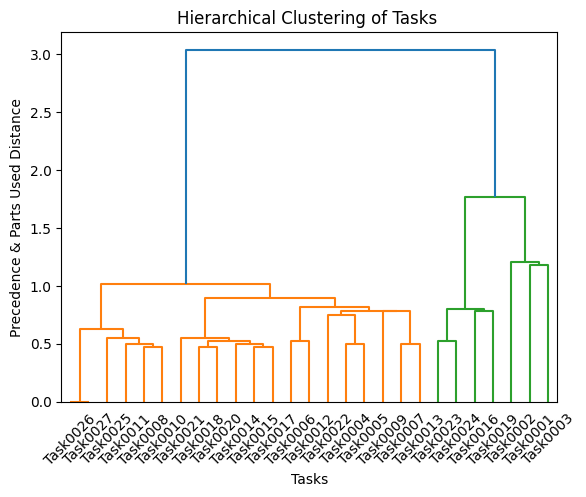

In [40]:
# define distance function
def task_distance(task1, task2):
    parts_sim = len(tasks[task1]['parts'].intersection(tasks[task2]['parts'])) / len(tasks[task1]['parts'].union(tasks[task2]['parts']))
    prec_weighted = precedence_weight * (task2 in tasks[task1]['precedency']) + precedence_weight * (task1 in tasks[task2]['precedency'])
    return parts_weight * (1 - parts_sim) + prec_weighted

#flow_weight*(np.abs(tasks[task1]["level"]-tasks[task2]["level"])+(tasks[task1]["ref_fam"]-tasks[task1]["ref_fam"]))
# compute pairwise distances
n_tasks = len(tasks)
dist_matrix = np.zeros((n_tasks, n_tasks))
for i, task1 in enumerate(tasks.keys()):
    for j, task2 in enumerate(tasks.keys()):
        if i < j:
            dist = task_distance(task1, task2)
            dist_matrix[i, j] = dist
            dist_matrix[j, i] = dist


# perform hierarchical clustering
clustering = linkage(dist_matrix, method='complete')
dendrogram(clustering, labels=list(tasks.keys()))
plt.title('Hierarchical Clustering of Tasks ')
plt.xlabel("Tasks")
plt.ylabel("Precedence & Parts Used Distance")
plt.show()

In [41]:
from scipy.cluster.hierarchy import linkage, fcluster
cluster_labels = fcluster(clustering, 0.5, criterion='distance')
print(list(cluster_labels))
clusters_ind = list(cluster_labels)
for task in tasks.values():
    task['target'] = clusters_ind.pop(0)

[17, 19, 18, 9, 9, 7, 11, 2, 12, 2, 2, 8, 11, 5, 5, 15, 5, 4, 16, 4, 6, 10, 13, 14, 3, 1, 1]


In [42]:
grouped_tasks = {}
for task_name, task in tasks.items():
    precedence_status = "no precedence" if not task["precedency"] else "has precedence"
    target_value = task["target"]

    if precedence_status not in grouped_tasks:
        grouped_tasks[precedence_status] = {}

    if target_value not in grouped_tasks[precedence_status]:
        grouped_tasks[precedence_status][target_value] = []

    grouped_tasks[precedence_status][target_value].append(task_name)

sorted_tasks = grouped_tasks

In [43]:
sorted_tasks

{'no precedence': {17: ['Task0001']},
 'has precedence': {19: ['Task0002'],
  18: ['Task0003'],
  9: ['Task0004', 'Task0005'],
  7: ['Task0006'],
  11: ['Task0007', 'Task0013'],
  2: ['Task0008', 'Task0010', 'Task0011'],
  12: ['Task0009'],
  8: ['Task0012'],
  5: ['Task0014', 'Task0015', 'Task0017'],
  15: ['Task0016'],
  4: ['Task0018', 'Task0020'],
  16: ['Task0019'],
  6: ['Task0021'],
  10: ['Task0022'],
  13: ['Task0023'],
  14: ['Task0024'],
  3: ['Task0025'],
  1: ['Task0026', 'Task0027']}}

In [23]:
def validate_assembly_sequence(task_dict, task_sequence):
    # Set of already assembled parts
    assembled_parts = set()
    
    # Keep track of completed tasks
    completed_tasks = set()
    
    for task_id in task_sequence:
        task = task_dict[task_id]
        
        # Check precedence constraints
        for prec_task in task['precedency']:
            if prec_task not in completed_tasks:
                return f"Task {task_id} cannot be executed before {prec_task}."

        # Check if parts are connected to previously assembled parts
        if not assembled_parts.intersection(task['parts']) and len(assembled_parts) > 0:
            return f"Task {task_id} has no parts connected to the previous assemblies."

        # Check forbidden tasks
        for forbidden_task in task['forbid']:
            if forbidden_task in completed_tasks:
                return f"Task {task_id} is forbidden after {forbidden_task}."

        # Mark task as completed
        completed_tasks.add(task_id)
        
        # Add assembled parts to the set of assembled parts
        assembled_parts.update(task['parts'])

    return "Assembly sequence is valid."

# Example usage
tasks = {
    'Task0001': {'id': 'Task0001', 'parts': {'3899059', '4300759'}, 'duration': 4.95, 'ref_fam': 19, 'level': 0, 'precedency': [], 'forbid': [], 'target': 17},
    'Task0002': {'id': 'Task0002', 'parts': {'3899059', '4386844'}, 'duration': 5.93, 'ref_fam': 14, 'level': 0, 'precedency': ['Task0001'], 'forbid': [], 'target': 19},
    'Task0003': {'id': 'Task0003', 'parts': {'4300759', '4386844'}, 'duration': 4.95, 'ref_fam': 19, 'level': 0, 'precedency': ['Task0001', 'Task0002'], 'forbid': [], 'target': 18},
    'Task0004': {'id': 'Task0004', 'parts': {'3899059', '4386844'}, 'duration': 4.95, 'ref_fam': 32, 'level': 0, 'precedency': ['Task0001', 'Task0002', 'Task0003'], 'forbid': [], 'target': 1},
}

task_sequence = ['Task0001', 'Task0002', 'Task0003', 'Task0004']

result = validate_assembly_sequence(tasks, task_sequence)
print(result)


Assembly sequence is valid.


In [57]:
def validate_machine_task_allocation(task_dict, machine_tasks):
    """
    Validate that all tasks assigned to a machine have related parts.
    
    :param task_dict: Dictionary of task definitions.
    :param machine_tasks: Dictionary of machine allocations. Format: {'Machine1': ['Task0001', 'Task0002', ...], ...}
    :return: Success message or error indicating which machine has unrelated tasks.
    """
    
    def are_tasks_connected(task_list):
        # Start with parts of the first task
        connected_parts = set(task_dict[task_list[0]]['parts'])
        
        # Check every subsequent task if it shares parts with the current connected parts
        for task_id in task_list[1:]:
            task_parts = task_dict[task_id]['parts']
            if not connected_parts.intersection(task_parts):
                return False
            # Add task's parts to connected parts
            connected_parts.update(task_parts)
        return True

    # Iterate through each machine and its assigned tasks
    for machine, tasks in machine_tasks.items():
        if not are_tasks_connected(tasks):
            return f"Machine {machine} has unrelated subassemblies in tasks: {tasks}"
    
    return "All machines have related tasks."

# Example usage
tasks = {
    'Task0001': {'id': 'Task0001', 'parts': {'1', '3'}, 'duration': 4.95, 'ref_fam': 19, 'level': 0, 'precedency': [], 'forbid': [], 'target': 17},
    'Task0002': {'id': 'Task0002', 'parts': {'1', '2'}, 'duration': 5.93, 'ref_fam': 14, 'level': 0, 'precedency': ['Task0001'], 'forbid': [], 'target': 19},
    'Task0003': {'id': 'Task0003', 'parts': {'2', '4'}, 'duration': 4.95, 'ref_fam': 19, 'level': 0, 'precedency': ['Task0001', 'Task0002'], 'forbid': [], 'target': 18},
    'Task0004': {'id': 'Task0004', 'parts': {'4', '5'}, 'duration': 4.95, 'ref_fam': 32, 'level': 0, 'precedency': ['Task0001', 'Task0002', 'Task0003'], 'forbid': [], 'target': 1},
    'Task0005': {'id': 'Task0005', 'parts': {'4', '7'}, 'duration': 4.95, 'ref_fam': 32, 'level': 0, 'precedency': ['Task0001', 'Task0002', 'Task0003'], 'forbid': [], 'target': 1},
    'Task0006': {'id': 'Task0006', 'parts': {'7', '8'}, 'duration': 4.95, 'ref_fam': 32, 'level': 0, 'precedency': ['Task0001', 'Task0002', 'Task0003'], 'forbid': [], 'target': 1},
    'Task0007': {'id': 'Task0007', 'parts': {'8', '9'}, 'duration': 4.95, 'ref_fam': 32, 'level': 0, 'precedency': ['Task0001', 'Task0002', 'Task0003'], 'forbid': [], 'target': 1},
    'Task0008': {'id': 'Task0008', 'parts': {'9', '10'}, 'duration': 4.95, 'ref_fam': 32, 'level': 0, 'precedency': ['Task0001', 'Task0002', 'Task0003'], 'forbid': [], 'target': 1},

}

machine_tasks = {
    'Machine1': ['Task0001', 'Task0002'],  # Valid, all tasks share parts
    'Machine2': ['Task0005', 'Task0006','Task0008'],  # Invalid, unrelated tasks
}

result = validate_machine_task_allocation(tasks, machine_tasks)
print(result)


Machine Machine2 has unrelated subassemblies in tasks: ['Task0005', 'Task0006', 'Task0008']


In [58]:
def find_feasible_tasks(task_dict):
    """
    For each task, find the list of other tasks that are feasible to assemble with (based on shared parts).
    
    :param task_dict: Dictionary of task definitions.
    :return: Dictionary where each task points to a list of feasible tasks.
    """
    feasible_tasks = {}
    
    # Iterate over each task in the task_dict
    for task_id, task in task_dict.items():
        # Initialize the list of feasible tasks for this task
        feasible_tasks[task_id] = []
        
        # Get the parts associated with the current task
        task_parts = set(task['parts'])
        
        # Compare with all other tasks to find common parts
        for other_task_id, other_task in task_dict.items():
            if other_task_id == task_id:
                continue  # Skip comparing the task with itself
            
            other_task_parts = set(other_task['parts'])
            
            # Check if there is any common part
            if task_parts.intersection(other_task_parts):
                feasible_tasks[task_id].append(other_task_id)
    
    return feasible_tasks

# Example usage
tasks = {
    'Task0001': {'id': 'Task0001', 'parts': {'1', '3'}, 'duration': 4.95, 'ref_fam': 19, 'level': 0, 'precedency': [], 'forbid': [], 'target': 17},
    'Task0002': {'id': 'Task0002', 'parts': {'1', '2'}, 'duration': 5.93, 'ref_fam': 14, 'level': 0, 'precedency': ['Task0001'], 'forbid': [], 'target': 19},
    'Task0003': {'id': 'Task0003', 'parts': {'2', '4'}, 'duration': 4.95, 'ref_fam': 19, 'level': 0, 'precedency': ['Task0001', 'Task0002'], 'forbid': [], 'target': 18},
    'Task0004': {'id': 'Task0004', 'parts': {'4', '5'}, 'duration': 4.95, 'ref_fam': 32, 'level': 0, 'precedency': ['Task0001', 'Task0002', 'Task0003'], 'forbid': [], 'target': 1},
    'Task0005': {'id': 'Task0005', 'parts': {'4', '7'}, 'duration': 4.95, 'ref_fam': 32, 'level': 0, 'precedency': ['Task0001', 'Task0002', 'Task0003'], 'forbid': [], 'target': 1},
    'Task0006': {'id': 'Task0006', 'parts': {'7', '8'}, 'duration': 4.95, 'ref_fam': 32, 'level': 0, 'precedency': ['Task0001', 'Task0002', 'Task0003'], 'forbid': [], 'target': 1},
    'Task0007': {'id': 'Task0007', 'parts': {'8', '9'}, 'duration': 4.95, 'ref_fam': 32, 'level': 0, 'precedency': ['Task0001', 'Task0002', 'Task0003'], 'forbid': [], 'target': 1},
    'Task0008': {'id': 'Task0008', 'parts': {'9', '10'}, 'duration': 4.95, 'ref_fam': 32, 'level': 0, 'precedency': ['Task0001', 'Task0002', 'Task0003'], 'forbid': [], 'target': 1},
}

# Get feasible tasks for each task
feasible_tasks = find_feasible_tasks(tasks)

# Output the feasible tasks
for task_id, feasible in feasible_tasks.items():
    print(f"Task {task_id} can assemble with: {feasible}")


Task Task0001 can assemble with: ['Task0002']
Task Task0002 can assemble with: ['Task0001', 'Task0003']
Task Task0003 can assemble with: ['Task0002', 'Task0004', 'Task0005']
Task Task0004 can assemble with: ['Task0003', 'Task0005']
Task Task0005 can assemble with: ['Task0003', 'Task0004', 'Task0006']
Task Task0006 can assemble with: ['Task0005', 'Task0007']
Task Task0007 can assemble with: ['Task0006', 'Task0008']
Task Task0008 can assemble with: ['Task0007']


## QL

In [45]:
## Task Object
class Part:
    def __init__(self, id, ref, duration, weight):
        self.id = id
        self.ref = ref
        self.duration = duration
        self.weight = weight

class Task:
    def __init__(self, id, parts, CT, preced_list, forbid_list):
        self.id = id
        self.parts = parts
        self.CT = CT
        self.preced_list = preced_list
        self.forbid_list = forbid_list
        self.clusterTasksID = []

Parts = []

for part_id, part in parts.items():
    part = Part(
        id=part['id'],
        ref=part['ref'],
        duration=part['duration'],
        weight=part['weight']
    )
    Parts.append(part)

Parts_ID = [part.id for part in Parts]

Tasks = []

for machine_id, machine in tasks.items():
    task = Task(
        id=machine['id'],
        parts=[Parts[Parts_ID.index(part)] for part in machine["parts"]],
        CT=machine['duration'],
        preced_list=machine['precedency'],
        forbid_list=machine['forbid']
    )
    Tasks.append(task)

Tasks_ID = [task.id for task in Tasks]

for cluster_id, tasks_id in sorted_tasks['no precedence'].items():
  if len(tasks_id) == 1:
      continue

  else:
    for i in range(len(tasks_id)):

      for task in Tasks:
        if task.id == tasks_id[i]:
          for task_id in tasks_id[:i] + tasks_id[i+1:]:
            task.clusterTasksID.append(Tasks_ID.index(task_id))



for cluster_id, tasks_id in sorted_tasks['has precedence'].items():
  if len(tasks_id) == 1:
    continue

  else:
    for i in range(len(tasks_id)):

      for task in Tasks:
        if task.id == tasks_id[i]:
          for task_id in tasks_id[:i] + tasks_id[i+1:]:
            task.clusterTasksID.append(Tasks_ID.index(task_id))



In [59]:

def are_tasks_connected(task_list):
    # Start with parts of the first task
    errs = 0
    connected_parts = {part.id for part in task_list[0].parts}
    
    # Check every subsequent task if it shares parts with the current connected parts
    for task in task_list[1:]:
        task_parts = {part.id for part in task.parts}
        if not connected_parts.intersection(task_parts):
            errs = errs+1
        # Add task's parts to connected parts
        connected_parts.update(task_parts)
    
    return True

# Validate machine allocations
def validate_machine_task_allocation(task_list_by_machine):
    """
    Validate that all tasks assigned to a machine have related parts.
    
    :param task_list_by_machine: Dictionary of machine allocations. Format: {'Machine1': [Task1, Task2, ...], ...}
    :return: Success message or error indicating which machine has unrelated tasks.
    """
    # Iterate through each machine and its assigned tasks
    for machine, tasks in task_list_by_machine.items():
        if not are_tasks_connected(tasks):
            return f"Machine {machine} has unrelated subassemblies in tasks: {[task.id for task in tasks]}"
    
    return "All machines have related tasks."



# Example allocation of tasks to machines
machine_tasks = {
    'Machine1': [Tasks[0], Tasks[1], Tasks[2]],  # All tasks related by parts
    'Machine2': [Tasks[0], Tasks[3]]  # Unrelated parts between Task0001 and Task0004
}

# Validate the machine allocations
result = validate_machine_task_allocation(machine_tasks)
print(result)


Machine Machine2 has unrelated subassemblies in tasks: ['Task0001', 'Task0004']


In [60]:
def find_feasible_tasks(task_dict):
    """
    For each task, find the list of other tasks that are feasible to assemble with (based on shared parts).
    
    :param task_dict: Dictionary of task definitions.
    :return: Dictionary where each task points to a list of feasible tasks.
    """
    feasible_tasks = {}
    
    # Iterate over each task in the task_dict
    for task_id, task in task_dict.items():
        # Initialize the list of feasible tasks for this task
        feasible_tasks[task_id] = []
        
        # Get the parts associated with the current task
        task_parts = set(task['parts'])
        
        # Compare with all other tasks to find common parts
        for other_task_id, other_task in task_dict.items():
            if other_task_id == task_id:
                continue  # Skip comparing the task with itself
            
            other_task_parts = set(other_task['parts'])
            
            # Check if there is any common part
            if task_parts.intersection(other_task_parts):
                feasible_tasks[task_id].append(other_task_id)
    
    return feasible_tasks

# Example usage
tasks = {
    'Task0001': {'id': 'Task0001', 'parts': {'1', '3'}, 'duration': 4.95, 'ref_fam': 19, 'level': 0, 'precedency': [], 'forbid': [], 'target': 17},
    'Task0002': {'id': 'Task0002', 'parts': {'1', '2'}, 'duration': 5.93, 'ref_fam': 14, 'level': 0, 'precedency': ['Task0001'], 'forbid': [], 'target': 19},
    'Task0003': {'id': 'Task0003', 'parts': {'2', '4'}, 'duration': 4.95, 'ref_fam': 19, 'level': 0, 'precedency': ['Task0001', 'Task0002'], 'forbid': [], 'target': 18},
    'Task0004': {'id': 'Task0004', 'parts': {'4', '5'}, 'duration': 4.95, 'ref_fam': 32, 'level': 0, 'precedency': ['Task0001', 'Task0002', 'Task0003'], 'forbid': [], 'target': 1},
    'Task0005': {'id': 'Task0005', 'parts': {'4', '7'}, 'duration': 4.95, 'ref_fam': 32, 'level': 0, 'precedency': ['Task0001', 'Task0002', 'Task0003'], 'forbid': [], 'target': 1},
    'Task0006': {'id': 'Task0006', 'parts': {'7', '8'}, 'duration': 4.95, 'ref_fam': 32, 'level': 0, 'precedency': ['Task0001', 'Task0002', 'Task0003'], 'forbid': [], 'target': 1},
    'Task0007': {'id': 'Task0007', 'parts': {'8', '9'}, 'duration': 4.95, 'ref_fam': 32, 'level': 0, 'precedency': ['Task0001', 'Task0002', 'Task0003'], 'forbid': [], 'target': 1},
    'Task0008': {'id': 'Task0008', 'parts': {'9', '10'}, 'duration': 4.95, 'ref_fam': 32, 'level': 0, 'precedency': ['Task0001', 'Task0002', 'Task0003'], 'forbid': [], 'target': 1},
}

# Get feasible tasks for each task
feasible_tasks = find_feasible_tasks(tasks)

# Output the feasible tasks
for task_id, feasible in feasible_tasks.items():
    print(f"Task {task_id} can assemble with: {feasible}")


Task Task0001 can assemble with: ['Task0002']
Task Task0002 can assemble with: ['Task0001', 'Task0003']
Task Task0003 can assemble with: ['Task0002', 'Task0004', 'Task0005']
Task Task0004 can assemble with: ['Task0003', 'Task0005']
Task Task0005 can assemble with: ['Task0003', 'Task0004', 'Task0006']
Task Task0006 can assemble with: ['Task0005', 'Task0007']
Task Task0007 can assemble with: ['Task0006', 'Task0008']
Task Task0008 can assemble with: ['Task0007']


In [ ]:
def find_feasible_tasks(tasks, task_id):
    """
    For each task, find the list of other tasks that are feasible to assemble with (based on shared parts).
    
    :param task_dict: Dictionary of task definitions.
    :return: Dictionary where each task points to a list of feasible tasks.
    """
    feasible_tasks = {}

    feasible_tasks[task_id] = []
    
    # Get the parts associated with the current task
    task_parts = set(tasks[task_id]['parts'])
    
    # Compare with all other tasks to find common parts
    for  other_task in tasks:
        if other_task.id == task_id:
            continue  # Skip comparing the task with itself
        
        other_task_parts = set(other_task.parts)
        
        # Check if there is any common part
        if task_parts.intersection(other_task_parts):
            feasible_tasks[task_id].append(other_task.id)
    
    return feasible_tasks

In [137]:
import random
from tqdm import tqdm
from tqdm import tqdm

class QLearning:

    def __init__(self, n_episodes, Tasks, targetCT, tolerance):
        self.Tasks = Tasks
        self.target = targetCT
        self.tolerance = tolerance
        self.solution = []
        self.session_rewards = []
        self.n_episodes = n_episodes

    def step(self, action):
        done = False
        new_state = action
        self.solution.append(new_state)

        if len(self.solution) == len(self.Tasks):
            done = True
        return new_state, done

    def split(self, a, n):
        k, m = divmod(len(a), n)
        return (a[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))

    def precedence_graph(self):
        preced_graph = []

        # No Precedence Restrictions
        preced_graph.append([task for task in self.Tasks if not task.preced_list])
        for task in self.Tasks:
            # A precedence restriction with one of the first group
            for preced_task in task.preced_list:
                if preced_task in preced_graph:
                    preced_graph.append(task)

    def get_nworkstations(self):
        total_ct = 0
        ct_WS = [0]
        tasks_WS = [[]]

        for i in self.solution:
          if ct_WS[-1]+float(self.Tasks[i].CT) > (1+self.tolerance)*(self.target / 2):
            ct_WS.append(float(self.Tasks[i].CT))
            tasks_WS.append([self.Tasks[i].id])
          else:
            ct_WS[-1]+=float(self.Tasks[i].CT)
            tasks_WS[-1].append(self.Tasks[i].id)

        return len(ct_WS), ct_WS, tasks_WS



    def objectiveR2(self):
        """
        Reward = -1 * (Number of Workstations Used) * (Number of Tasks Completed)
        This reward function takes into account both the number of tasks completed and the number of workstations used up to
        the current time. By multiplying the number of tasks completed with the negative of the number of workstations used,
        the reward function encourages the agent to complete as many tasks as possible while minimizing the number of workstations
        used.
        The partial reward can be calculated at each step of the assembly process, after each task is completed. The agent can
        then use this partial reward to update its policy and choose the next task to be completed based on the updated policy.

        Note that this partial reward function assumes that all tasks have the same complexity and require the same amount of time and resources. If this is not the case, you may need to modify the reward function to take into account the specific characteristics of each task.
        """
        if len(self.solution) == len(self.Tasks):
          n, CTs, _ = self.get_nworkstations()
          m, CTsWorkers = self.estimate_WC()
          cost_empty_workstation = -10 if n % 2 == 0 else 10

          reward =-n*np.var(CTs)-m*np.var(CTsWorkers)-cost_empty_workstation-1000*self.check_forbid_full(self.solution)
          #reward =-n*np.var(CTs)-m*np.var(CTsWorkers)-cost_empty_workstation

        else:
          reward = -100000 #Sequence infeasible

        #reward = (-n-n*np.std(CTs)-m*np.std(CTsWorkers)+self.cluster_reward()+self.check_precedence()+self.check_forbid())*len(self.solution)
        #reward = (-n-m+self.cluster_reward()+self.check_forbid()+self.check_precedence()+cost_empty_workstation)*len(self.solution)
        #reward = (-n-m+self.check_forbid())*len(self.solution)
        return reward

    def objectiveR2_final(self):
        """
        Reward = -1 * (Number of Workstations Used) * (Number of Tasks Completed)
        This reward function takes into account both the number of tasks completed and the number of workstations used up to
        the current time. By multiplying the number of tasks completed with the negative of the number of workstations used,
        the reward function encourages the agent to complete as many tasks as possible while minimizing the number of workstations
        used.
        The partial reward can be calculated at each step of the assembly process, after each task is completed. The agent can
        then use this partial reward to update its policy and choose the next task to be completed based on the updated policy.

        Note that this partial reward function assumes that all tasks have the same complexity and require the same amount of time and resources. If this is not the case, you may need to modify the reward function to take into account the specific characteristics of each task.
        """
        n, CTs, _ = self.get_nworkstations()
        m, CTsWorkers = self.estimate_WC()
        if CTsWorkers == []:
          m,CTsWorkers = 0, [0]
        cost_empty_workstation = -100 if len(CTs) % 2 == 0 else 100

        reward = (-n*n-n*np.std(CTs)-n*np.max(CTs)-m*np.std(CTsWorkers)-n*cost_empty_workstation+self.cluster_reward()+ self.check_precedence())*len(self.solution)
        print("CT Machines = " + str(np.std(CTs))  + " - CT workers = " + str(np.std(CTsWorkers)))
        print("Cluster reward = " + str(self.cluster_reward())  + " - Check precedence = " + str(self.check_precedence()))
        #reward = (self.cluster_reward() + self.check_precedence() -n)*len(self.solution)
        return reward

    def estimate_WC(self):
        n_workers = 1
        total_ct = 0
        parts_done = []
        ct_Workers = []
        for i in self.solution:
            total_ct += sum([float(part.duration) for part in self.Tasks[i].parts if part not in parts_done])
            total_ct += sum([3 for part in self.Tasks[i].parts if part in parts_done])
            for p in self.Tasks[i].parts:
                parts_done.append(p)

            if total_ct >= self.target:
                n_workers += 1
                ct_Workers.append(total_ct)
                total_ct = 0

        if n_workers == 1:
            ct_Workers.append(total_ct)
        return n_workers, ct_Workers

    def sequence_to_scenario(self, indiv):
      Tasks_ID = [task.id for task in self.Tasks]

      total_ct = 0
      groups = []
      group = []
      for i in indiv:
          total_ct += float(self.Tasks[i].CT)
          group.append(i)
          if total_ct >= (1+self.tolerance)*(self.target / 2):
              groups.append(group.copy())
              total_ct = 0
              group=[]

      if total_ct > 0:
        if total_ct <= 0.3*(self.target / 2):
          groups[-1] = groups[-1] + group
        else:
          groups.append(group.copy())

      scenario = [0 for i in range(len(Tasks_ID))]
      for i in range(len(groups)):
        for j in groups[i]:
          scenario[j] = i+1
      return scenario

    def sequence_to_scenario2(self, ant, final=False):
      total_ct = 0
      scenario = [0 for i in range(len(ant))]
      n_workstations = 1
      for i in ant:
            total_ct += float(self.Tasks[i].CT)
            if total_ct >= (self.target / 2):
                n_workstations += 1
                total_ct = 0
            scenario[i] = n_workstations

      return scenario

    def update_feasible_actions(self, state, actions):
        '''
        The only restriction is that a certain node x is not allowed to be vis-ited unless all the predecessor nodes are visited prior to n.
        '''

        # We remove last action from the possible actions of next step
        #new_actions = list(actions).copy()
        new_actions = list(range(len(self.Tasks)))
        for act in self.solution:
          new_actions.remove(act)
        # We add all new possible actions to it now (tasks that get now unlocked)
        # Tasks_ID = [task.id for task in self.Tasks]

        # new_unlocked = [self.Tasks.index(task) for task in self.Tasks if (
        #             all(Tasks_ID.index(item) in self.solution for item in task.preced_list) and self.Tasks.index(
        #         task) not in self.solution and self.Tasks.index(task) not in new_actions)]
        # for task_ind in new_unlocked:
        #     new_actions.append(task_ind)

        # print("Old actions = ", new_actions)
        # Keep only the one mehcanically feasible
        new_actions_all = []
        for action in new_actions:
            other_task_parts = set(self.Tasks[action].parts)
            # Check if there is any common part
            if set(self.Tasks[state].parts).intersection(other_task_parts):
                new_actions_all.append(action)

        if new_actions_all == []:
          new_actions_all = new_actions.copy()
        return new_actions_all


    def find_feasible_tasks(self, state, actions, tasks, task_id):
        """
        For each task, find the list of other tasks that are feasible to assemble with (based on shared parts).
        
        :param task_dict: Dictionary of task definitions.
        :return: Dictionary where each task points to a list of feasible tasks.
        """
        new_actions = list(actions).copy()
        new_actions.remove(state)
        Tasks_ID = [task.id for task in self.Tasks]

        feasible_tasks = {}

        feasible_tasks[task_id] = []
        
        # Get the parts associated with the current task
        task_parts = set(tasks[task_id]['parts'])
        
        # Compare with all other tasks to find common parts
        for other_task in tasks:
            if other_task.id == task_id:
                continue  # Skip comparing the task with itself
            
            other_task_parts = set(other_task.parts)
            
            # Check if there is any common part
            if task_parts.intersection(other_task_parts):
                feasible_tasks[task_id].append(other_task.id)
        
        return feasible_tasks


    def cluster_reward(self):

      if self.solution[-1] in self.prefered_actions(self.solution[-2]) or self.solution[-2] in self.prefered_actions(self.solution[-1]):
          return 100
      else:
        return -10

    def get_feasible_actions(self, state):
      new_actions = []
      Tasks_ID = [task.id for task in self.Tasks]

      new_unlocked = [self.Tasks.index(task) for task in self.Tasks if (
                  all(Tasks_ID.index(item) in self.solution for item in task.preced_list) and (self.Tasks.index(task) not in self.solution))]
      print(new_unlocked)
      for task_ind in new_unlocked:
          new_actions.append(task_ind)

      return new_actions

    def prefered_actions(self, state):
      prefered_tasks = list(self.Tasks[state].clusterTasksID).copy()
      return prefered_tasks

    def get_prefered_actions(self, state):

      prefered_tasks = list(self.Tasks[state].clusterTasksID).copy()
      for ind in prefered_tasks:
        if ind in self.solution:
          prefered_tasks.remove(ind)


      return prefered_tasks

    def check_precedence(self):
      Tasks_ID = [task.id for task in self.Tasks]
      if self.Tasks[self.solution[-1]].preced_list != []:
        if not all(Tasks_ID.index(item) in self.solution[:-1] for item in self.Tasks[self.solution[-1]].preced_list):

          return -100
        else:
          return 100
      else:
        return 0

    def check_forbid(self):
      Tasks_ID = [task.id for task in self.Tasks]

      total_ct = 0
      groups = []
      group = []
      for i in self.solution:
          total_ct += float(self.Tasks[i].CT)
          group.append(i)
          if total_ct >= (self.target / 2):
              groups.append(group.copy())
              total_ct = 0
              group=[]

      groups.append(group.copy())

      if self.Tasks[self.solution[-1]].forbid_list != []:
        for i in range(len(groups)):
          if self.solution[-1] in groups[i]:
            if all(Tasks_ID.index(item) not in groups[i] for item in self.Tasks[self.solution[-1]].forbid_list):
              return 10
            else:
              return -10
      else:
        return 0


    def check_forbid_full(self, indiv):
      Tasks_ID = [task.id for task in self.Tasks]

      total_ct = 0
      groups = []
      group = []
      for i in indiv:
          total_ct += float(self.Tasks[i].CT)
          group.append(i)
          if total_ct >= (self.target / 2):
              groups.append(group.copy())
              total_ct = 0
              group=[]

      groups.append(group.copy())
      j=0
      for i in range(len(groups)):
        if groups[i] != []:
          j = j + self.are_tasks_connected([self.Tasks[ind] for ind in groups[i]])
        else:
          j = j + 1

      return j

    def check_precedence_full_sequence(self):
      Tasks_ID = [task.id for task in self.Tasks]
      j=0
      for i in range(len(self.solution)-1):
        if self.Tasks[self.solution[i+1]].preced_list != []:
          if not all(Tasks_ID.index(item) in self.solution[:i+1] for item in self.Tasks[self.solution[i+1]].preced_list):
            j+=1
      return j

    def check_precedence_final(self, candidate):
      Tasks_ID = [task.id for task in self.Tasks]
      j=0
      for i in range(len(candidate)-1):
        if self.Tasks[candidate[i+1]].preced_list != []:
          if not all(Tasks_ID.index(item) in candidate[:i+1] for item in self.Tasks[candidate[i+1]].preced_list):
            j+=1
      return j
    
    
    
    def find_feasible_tasks(self):
      """
      For each task, find the list of other tasks that are feasible to perform next, 
      based on task dependencies (precedency) and shared parts.
      
      :return: Dictionary where each task points to a list of feasible tasks.
      """
      feasible_tasks = {}
      
      # List of all task IDs
      Tasks_ID = [task.id for task in self.Tasks]
      
      # Iterate over each task in self.Tasks
      for task in self.Tasks:
          task_id = task.id
          feasible_tasks[task_id] = []  # Initialize the list of feasible tasks for this task
          
          # Get the parts associated with the current task
          task_parts = set([part.id for part in task.parts])
          
          # Compare with all other tasks to find shared parts and unlocked tasks
          for other_task in self.Tasks:
              other_task_id = other_task.id
              if other_task_id == task_id:
                  continue  # Skip comparing the task with itself
              
              # Check if all predecessor tasks of the other task are completed
              # if all(Tasks_ID.index(preced_task) in self.solution for preced_task in other_task.preced_list):
              other_task_parts = set([part.id for part in other_task.parts])
              
              # Check if there are common parts between the current task and the other task
              if task_parts.intersection(other_task_parts):
                  feasible_tasks[task_id].append(other_task_id)
      
      ##TODO: multiply number of errors by a negative reward
      return feasible_tasks
    
    def are_tasks_connected(self, task_list):
      # Start with parts of the first task
      errs = 0
      connected_parts = {part.id for part in task_list[0].parts}
      
      # Check every subsequent task if it shares parts with the current connected parts
      for task in task_list[1:]:
          task_parts = {part.id for part in task.parts}
          if not connected_parts.intersection(task_parts):
              errs = errs+1
          # Add task's parts to connected parts
          connected_parts.update(task_parts)
      
      return errs

    



    def train(self, n_episodes=3000, exploration_prob=1, gamma=0.5, lr=0.001):

        number_workstations_per_episode = []
        exploration_decreasing_decay = 0.01
        min_exploration_prob = 0.1
        max_workstations = np.sum([float(t.CT) for t in self.Tasks])//self.target + 5
        max_workers = max_workstations
        actions = range(len(self.Tasks))
        states = range(len(self.Tasks))

        q_table = np.zeros((len(states), len(actions)))
        reward = np.full((len(states), len(actions)), -1000)

        pbar = tqdm(range(self.n_episodes), desc="QLearning", colour='green')

        reward_global = [0,0,0]
        for e in pbar:
            done = False
            current_state = 0
            self.solution = []

            #actions = [self.Tasks.index(task) for task in self.Tasks if not task.preced_list]

            actions = [self.Tasks.index(task) for task in self.Tasks]
            while not done:
                if np.random.uniform(0, 1) < exploration_prob or e<0.2*self.n_episodes:
                  action = random.choice(actions)
                else:
                  action = actions[np.argmax([q_table[current_state, i] for i in actions])]

                next_state, done = self.step(action)
                if len(self.solution) > 1:
                  reward[self.solution[-2], self.solution[-1]] = reward[self.solution[-2], self.solution[-1]]+ self.cluster_reward() + self.check_precedence()
                actions = self.update_feasible_actions(next_state, actions)

                if actions == []:
                  done = True

                current_state = next_state

            # TODO: Integrate a reward per state/action related to starting with longer task.
            global_reward = self.objectiveR2()
            for i, state_i in enumerate(self.solution):
                if i < len(self.solution) - 1:
                    reward[state_i, self.solution[i + 1]] = (reward[state_i, self.solution[i + 1]] + global_reward) / 2
                    #reward[state_i, self.solution[i + 1]] = self.objectiveR2() - reward_global[0]/self.target - np.std(reward_global[1]) - np.std(reward_global[2])
                    q_table[state_i, self.solution[i + 1]] = (1 - lr) * q_table[state_i, self.solution[i + 1]] + lr * (
                                reward[state_i, self.solution[i + 1]] + gamma * max(q_table[:, self.solution[i + 1]]))

            exploration_prob = max(min_exploration_prob, np.exp(-exploration_decreasing_decay * e))
            pbar.set_postfix({"Reward": np.mean(reward)})
            # print("Exploration prob = ", exploration_prob)
            self.session_rewards.append(np.mean(reward))
            number_workstations_per_episode.append(self.get_nworkstations()[0])


        plt.plot(self.session_rewards)
        plt.show()
        done = False
        current_state = 0

        self.solution = []
        #actions = self.update_feasible_actions(current_state, [self.Tasks.index(task) for task in self.Tasks if not task.preced_list])
        actions = [self.Tasks.index(task) for task in self.Tasks]
        while not done:
            action = actions[np.argmax([q_table[current_state, a] for a in actions])]
            next_state, done = self.step(action)
            actions = self.update_feasible_actions(next_state, actions)
            current_state = next_state

        indiv = self.sequence_to_scenario(self.solution)

        return indiv, 0, self.get_nworkstations()[0], self.get_nworkstations()[2], 0

In [87]:
total_duration = sum(task['duration'] for task in tasks.values())
print(total_duration)

324.37000000000006


============ Itertion 1  ===============
{'Task0001': ['Task0002', 'Task0003', 'Task0006', 'Task0012'], 'Task0002': ['Task0001', 'Task0003'], 'Task0003': ['Task0001', 'Task0002', 'Task0006', 'Task0012'], 'Task0004': ['Task0005'], 'Task0005': ['Task0004', 'Task0006'], 'Task0006': ['Task0001', 'Task0003', 'Task0005', 'Task0012'], 'Task0007': ['Task0013'], 'Task0008': ['Task0009', 'Task0010', 'Task0011', 'Task0025', 'Task0026', 'Task0027'], 'Task0009': ['Task0008', 'Task0010'], 'Task0010': ['Task0008', 'Task0009', 'Task0011', 'Task0025', 'Task0026', 'Task0027'], 'Task0011': ['Task0008', 'Task0010', 'Task0025', 'Task0026', 'Task0027'], 'Task0012': ['Task0001', 'Task0003', 'Task0006', 'Task0013'], 'Task0013': ['Task0007', 'Task0012'], 'Task0014': ['Task0015', 'Task0017', 'Task0018', 'Task0020', 'Task0021'], 'Task0015': ['Task0014', 'Task0016', 'Task0017', 'Task0018', 'Task0020', 'Task0021'], 'Task0016': ['Task0015', 'Task0017'], 'Task0017': ['Task0014', 'Task0015', 'Task0016', 'Task0018', '

QLearning: 100%|██████████| 100000/100000 [05:35<00:00, 297.86it/s, Reward=-2.83e+3]


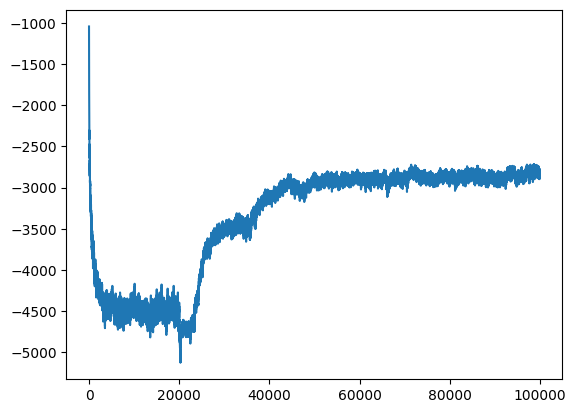

best solution =  [1, 1, 1, 2, 2, 1, 9, 4, 9, 3, 3, 8, 8, 5, 6, 6, 6, 6, 6, 6, 6, 9, 7, 7, 3, 4, 5]
best solution sequence =  [0, 1, 2, 5, 4, 3, 24, 9, 10, 7, 25, 26, 13, 16, 15, 14, 17, 19, 18, 20, 22, 23, 11, 12, 6, 21, 8]
n machines =  18
reward =  (18, [15.829999999999998, 18.09, 18.09, 15.18, 17.51, 22.58, 25.83, 19.43, 20.62, 14.64, 18.29, 18.22, 12.34, 16.58, 15.18, 20.2, 32.46, 3.3], [['Task0001', 'Task0002', 'Task0003'], ['Task0006'], ['Task0005'], ['Task0004'], ['Task0025', 'Task0010'], ['Task0011', 'Task0008'], ['Task0026'], ['Task0027'], ['Task0014', 'Task0017', 'Task0016'], ['Task0015', 'Task0018', 'Task0020', 'Task0019'], ['Task0021'], ['Task0023'], ['Task0024'], ['Task0012'], ['Task0013'], ['Task0007'], ['Task0022'], ['Task0009']])
Precedence =  4
============ Itertion 2  ===============
{'Task0001': ['Task0002', 'Task0003', 'Task0006', 'Task0012'], 'Task0002': ['Task0001', 'Task0003'], 'Task0003': ['Task0001', 'Task0002', 'Task0006', 'Task0012'], 'Task0004': ['Task0005']

QLearning: 100%|██████████| 100000/100000 [05:21<00:00, 310.96it/s, Reward=-3.1e+3]


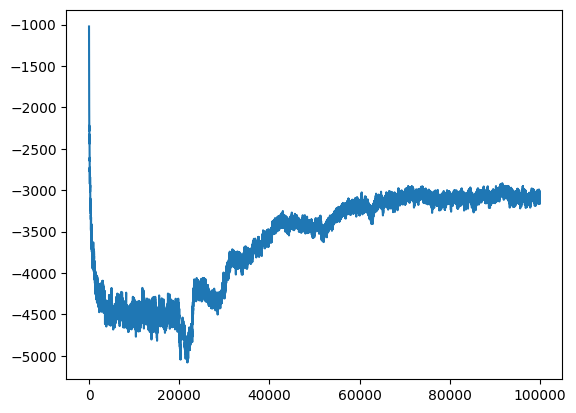

best solution =  [1, 1, 1, 9, 9, 1, 3, 6, 8, 8, 6, 2, 2, 8, 3, 4, 4, 8, 10, 8, 4, 10, 5, 5, 7, 6, 7]
best solution sequence =  [0, 1, 2, 5, 11, 12, 6, 14, 15, 16, 20, 22, 23, 7, 10, 25, 26, 24, 9, 8, 19, 17, 13, 4, 3, 21, 18]
n machines =  18
reward =  (18, [15.829999999999998, 18.09, 16.58, 15.18, 20.2, 10.51, 18.29, 18.22, 16.24, 18.68, 25.83, 19.43, 20.810000000000002, 22.42, 18.09, 15.18, 32.46, 2.33], [['Task0001', 'Task0002', 'Task0003'], ['Task0006'], ['Task0012'], ['Task0013'], ['Task0007'], ['Task0015', 'Task0016', 'Task0017'], ['Task0021'], ['Task0023'], ['Task0024', 'Task0008'], ['Task0011'], ['Task0026'], ['Task0027'], ['Task0025', 'Task0010', 'Task0009'], ['Task0020', 'Task0018', 'Task0014'], ['Task0005'], ['Task0004'], ['Task0022'], ['Task0019']])
Precedence =  4
============ Itertion 3  ===============
{'Task0001': ['Task0002', 'Task0003', 'Task0006', 'Task0012'], 'Task0002': ['Task0001', 'Task0003'], 'Task0003': ['Task0001', 'Task0002', 'Task0006', 'Task0012'], 'Task000

QLearning: 100%|██████████| 100000/100000 [05:12<00:00, 319.83it/s, Reward=-3.14e+3]


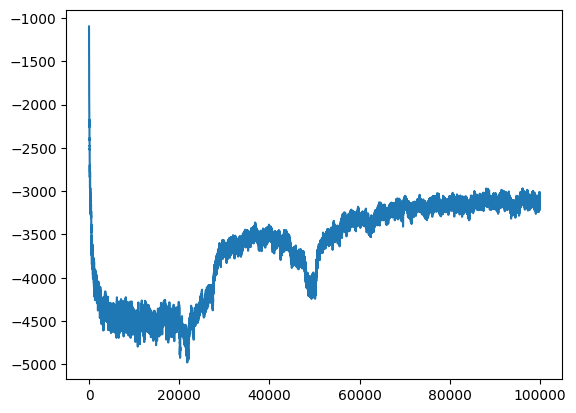

best solution =  [1, 1, 1, 2, 2, 1, 6, 4, 9, 4, 4, 5, 6, 7, 9, 9, 9, 9, 9, 9, 7, 9, 8, 8, 4, 3, 5]
best solution sequence =  [0, 1, 2, 5, 4, 3, 25, 9, 24, 7, 10, 26, 11, 12, 6, 13, 20, 22, 23, 16, 15, 14, 19, 17, 18, 21, 8]
n machines =  18
reward =  (18, [15.829999999999998, 18.09, 18.09, 15.18, 25.83, 21.41, 18.68, 19.43, 16.58, 15.18, 20.2, 14.69, 18.29, 18.22, 18.27, 14.64, 32.46, 3.3], [['Task0001', 'Task0002', 'Task0003'], ['Task0006'], ['Task0005'], ['Task0004'], ['Task0026'], ['Task0010', 'Task0025', 'Task0008'], ['Task0011'], ['Task0027'], ['Task0012'], ['Task0013'], ['Task0007'], ['Task0014'], ['Task0021'], ['Task0023'], ['Task0024', 'Task0017', 'Task0016'], ['Task0015', 'Task0020', 'Task0018', 'Task0019'], ['Task0022'], ['Task0009']])
Precedence =  4
============ Itertion 4  ===============
{'Task0001': ['Task0002', 'Task0003', 'Task0006', 'Task0012'], 'Task0002': ['Task0001', 'Task0003'], 'Task0003': ['Task0001', 'Task0002', 'Task0006', 'Task0012'], 'Task0004': ['Task0005']

QLearning: 100%|██████████| 100000/100000 [05:25<00:00, 307.36it/s, Reward=-3.55e+3]


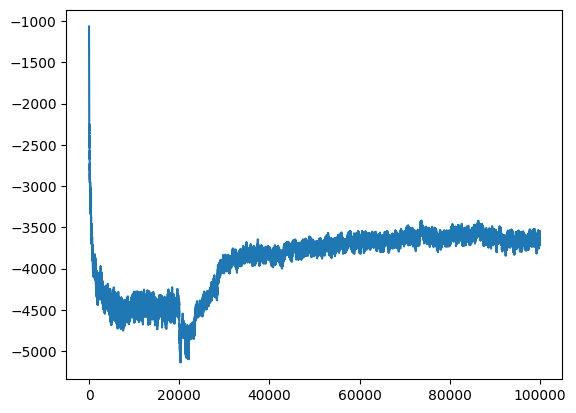

best solution =  [1, 1, 1, 8, 9, 1, 3, 3, 4, 4, 4, 2, 2, 6, 6, 10, 6, 6, 10, 6, 5, 9, 10, 10, 5, 7, 8]
best solution sequence =  [0, 1, 2, 5, 11, 12, 6, 7, 8, 9, 10, 24, 20, 17, 19, 16, 14, 13, 25, 26, 3, 4, 21, 22, 23, 18, 15]
n machines =  18
reward =  (18, [15.829999999999998, 18.09, 16.58, 15.18, 20.2, 9.899999999999999, 18.68, 14.81, 18.29, 15.39, 14.69, 25.83, 19.43, 15.18, 18.09, 32.46, 18.22, 17.52], [['Task0001', 'Task0002', 'Task0003'], ['Task0006'], ['Task0012'], ['Task0013'], ['Task0007'], ['Task0008', 'Task0009', 'Task0010'], ['Task0011'], ['Task0025'], ['Task0021'], ['Task0018', 'Task0020', 'Task0017', 'Task0015'], ['Task0014'], ['Task0026'], ['Task0027'], ['Task0004'], ['Task0005'], ['Task0022'], ['Task0023'], ['Task0024', 'Task0019', 'Task0016']])
Precedence =  1
============ Itertion 5  ===============
{'Task0001': ['Task0002', 'Task0003', 'Task0006', 'Task0012'], 'Task0002': ['Task0001', 'Task0003'], 'Task0003': ['Task0001', 'Task0002', 'Task0006', 'Task0012'], 'Task0

QLearning: 100%|██████████| 100000/100000 [05:47<00:00, 287.62it/s, Reward=-2.83e+3]


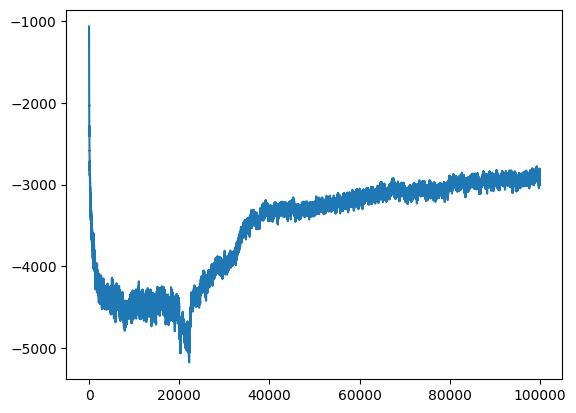

best solution =  [1, 1, 1, 9, 9, 1, 3, 6, 9, 7, 6, 2, 2, 3, 4, 4, 4, 4, 4, 4, 4, 8, 5, 5, 6, 7, 8]
best solution sequence =  [0, 1, 2, 5, 11, 12, 6, 13, 19, 18, 17, 14, 15, 16, 20, 22, 23, 7, 10, 24, 9, 25, 26, 21, 4, 3, 8]
n machines =  17
reward =  (17, [15.829999999999998, 18.09, 16.58, 15.18, 20.2, 20.17, 15.09, 18.29, 18.22, 16.24, 18.68, 17.51, 25.83, 19.43, 32.46, 18.09, 18.48], [['Task0001', 'Task0002', 'Task0003'], ['Task0006'], ['Task0012'], ['Task0013'], ['Task0007'], ['Task0014', 'Task0020', 'Task0019'], ['Task0018', 'Task0015', 'Task0016', 'Task0017'], ['Task0021'], ['Task0023'], ['Task0024', 'Task0008'], ['Task0011'], ['Task0025', 'Task0010'], ['Task0026'], ['Task0027'], ['Task0022'], ['Task0005'], ['Task0004', 'Task0009']])
Precedence =  4


FileNotFoundError: [Errno 2] No such file or directory: './results/L76D_results_100000.csv'

In [142]:
import csv

indivs = []
results = []
n_episodes = 100000


for i in range(5):
  print("============ Itertion " + str(i+1) +"  ===============")
  ql = QLearning(n_episodes, Tasks, targetCT=38, tolerance=0.2)
  # ql.solution = [0,7, 6,1,32]
  print(ql.find_feasible_tasks())

  #print(ql.prefered_actions(0))
  best_solution, best_ct, n_machines,_,  n_workers = ql.train()
  print("best solution = ", best_solution)
  print("best solution sequence = ", ql.solution)
  print("n machines = ", n_machines)
  print("reward = ", ql.get_nworkstations())
  print("Precedence = ", ql.check_precedence_final(ql.solution))
  indivs.append(best_solution)
  results.append({
        'Iteration': i + 1,
        'Best Solution': best_solution,
        'Best Solution Sequence': ql.solution,
        'N Machines': n_machines,
        'Reward': ql.get_nworkstations(),
        'Precedence': ql.check_precedence_final(ql.solution)
    })

# Define the CSV file path
csv_file = './results/L76D_results_'+str(n_episodes)+'.csv'

# Define the column names
fieldnames = ['Iteration', 'Best Solution', 'Best Solution Sequence', 'N Machines', 'Reward', 'Precedence']

# Write the results to the CSV file
with open(csv_file, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fieldnames)

    # Write the header
    writer.writeheader()

    # Write the rows
    for result in results:
        writer.writerow(result)

print("Results saved to", csv_file)

In [139]:
ql.check_forbid_full([0, 1, 2, 5, 11, 12, 6, 20, 14, 16, 19, 17, 18, 13, 7, 8, 9, 24, 10, 25, 26, 3, 4, 21, 22, 23, 15])

0